In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

from pytz import timezone
from geopy.distance import geodesic

import matplotlib
import matplotlib.dates as mdates

In [2]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [ ]:
output_dir = '../metadata/14-06-2024'
filename = 'location-error.png'

In [3]:
start_location = (1.309445687403374, 103.8945458856887)
stop_location = (1.3529034694080613, 103.87632796340252)

In [4]:
conn = psycopg2.connect(
    host="localhost",
    database="gpx",
    user="root",
    password="root"
)

In [5]:
def query_postgis(device_table_name):
    query = f"""
WITH ordered_route_points AS (
    SELECT location
    FROM gpx_route
    ORDER BY id
),
route_linestring AS (
    SELECT ST_MakeLine(ST_Transform(location, 3857)) AS route
    FROM ordered_route_points
)

SELECT
    time,
    ST_Y(location) AS latitude,
    ST_X(location) AS longitude,
    ST_Distance(ST_Transform(location, 3857), (SELECT route FROM route_linestring)) AS distance_to_route
FROM
    {device_table_name};
"""
    
    with conn.cursor() as cur:
        cur.execute(query)
        rows = cur.fetchall()

    df = pd.DataFrame(rows, columns=["time", "latitude", "longitude", "distance_to_route"])
    df['time'] = df['time'].apply(lambda x: x.astimezone(timezone('Asia/Singapore')))
    
    return df

In [6]:
garmin_df = query_postgis('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-14 21:42:00+08:00,1.309462,103.896110,177.667839
1,2024-06-14 21:42:09+08:00,1.309428,103.896120,176.944175
2,2024-06-14 21:42:19+08:00,1.309443,103.896051,170.922153


In [7]:
polar_df = query_postgis('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-14 21:42:23.270000+08:00,1.309432,103.896152,180.229824
1,2024-06-14 21:42:24.271000+08:00,1.309457,103.896145,180.869332
2,2024-06-14 21:42:25.271000+08:00,1.309455,103.896138,180.125676


In [8]:
def crop_route(df, start_point_count):
    df['start_distance'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), start_location).meters, axis=1)
    df['stop_distance'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), stop_location).meters, axis=1)
    
    start_point_idx = df.iloc[:start_point_count]['start_distance'].idxmin()
    end_point_idx = df.iloc[-200:]['stop_distance'].idxmin()
    
    df = df.iloc[start_point_idx:end_point_idx]
    
    return df

In [9]:
garmin_df = crop_route(garmin_df, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
12,2024-06-14 21:43:21+08:00,1.309501,103.894629,79.249385,11.055872,5213.505613
13,2024-06-14 21:43:26+08:00,1.309361,103.894640,63.662028,14.038920,5228.221104
14,2024-06-14 21:43:33+08:00,1.309173,103.894688,42.798133,34.048641,5249.469379


In [10]:
polar_df = crop_route(polar_df, 600)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
61,2024-06-14 21:43:24.271000+08:00,1.309450,103.894612,73.694632,7.336690,5217.955296
62,2024-06-14 21:43:25.271000+08:00,1.309428,103.894615,71.261368,7.927615,5220.306309
63,2024-06-14 21:43:26.271000+08:00,1.309405,103.894617,68.656965,9.071829,5222.754431


In [11]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

              Polar       Garmin
count  26849.000000  5806.000000
mean      12.205283    12.584278
std       23.752298    26.026301
min        0.000536     0.001572
25%        2.998031     2.538568
50%        6.166509     5.978562
75%       11.804859    11.510435
max      198.990322   202.455530


NameError: name 'output_dir' is not defined

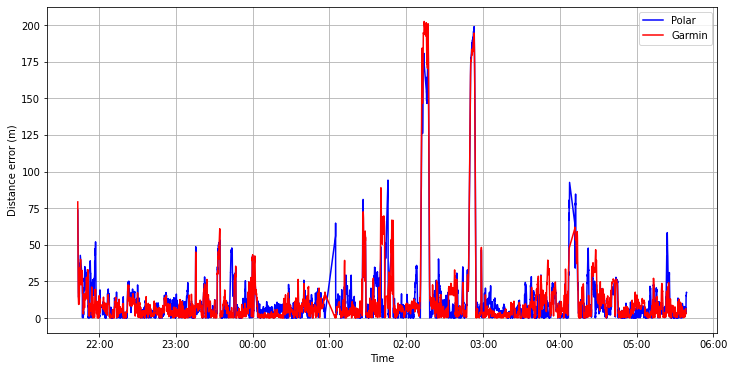

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/' + filename)